## Solving Sudoku using Grover's Algorithm <a id="sudoku"></a>

We will now solve a simple problem using Grover's algorithm, for which we do not necessarily know the solution beforehand. Our problem is a 2×2 binary sudoku, which in our case has two simple rules:

- No column may contain the same value twice
- No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

![2×2 binary sudoku, with each square allocated to a different variable](images/binary_sudoku.png)

we want our circuit to output a solution to this sudoku.

Note that, while this approach of using Grover's algorithm to solve this problem is not practical (you can probably find the solution in your head!), the purpose of this example is to demonstrate the conversion of classical [decision problems](https://en.wikipedia.org/wiki/Decision_problem) into oracles for Grover's algorithm.

### 1. Turning the Problem into a Circuit

We want to create an oracle that will help us solve this problem, and we will start by creating a circuit that identifies a correct solution. Similar to how we created a classical adder using quantum circuits in [_The Atoms of Computation_](/course/ch-states/the-atoms-of-computation), we simply need to create a _classical_ function on a quantum circuit that checks whether the state of our variable bits is a valid solution.

Since we need to check down both columns and across both rows, there are 4 conditions we need to check:

```
v0 ≠ v1   # check along top row
v2 ≠ v3   # check along bottom row
v0 ≠ v2   # check down left column
v1 ≠ v3   # check down right column
```

Remember we are comparing classical (computational basis) states. For convenience, we can compile this set of comparisons into a list of clauses:

In [2]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

We will assign the value of each variable to a bit in our circuit. To check these clauses computationally, we will use the `XOR` gate (we came across this in the atoms of computation).

In [3]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

Convince yourself that the `output0` bit in the circuit below will only be flipped if `input0 ≠ input1`:

In [4]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit, ClassicalRegister
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

input_0: ──■───────
           │       
input_1: ──┼────■──
         ┌─┴─┐┌─┴─┐
 output: ┤ X ├┤ X ├
         └───┘└───┘

This circuit checks whether `input0 == input1` and stores the output to `output0`. To check each clause, we repeat this circuit for each pairing in `clause_list` and store the output to a new bit:

In [5]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

v_0: ──■─────────■───────────────────────────
       │         │                           
v_1: ──┼────■────┼─────────■─────────────────
       │    │    │         │                 
v_2: ──┼────┼────┼────■────┼─────────■───────
       │    │    │    │    │         │       
v_3: ──┼────┼────┼────┼────┼────■────┼────■──
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼──
                         └───┘└───┘┌─┴─┐┌─┴─┐
c_3: ──────────────────────────────┤ X ├┤ X ├
                                   └───┘└───┘

The final state of the bits `c0, c1, c2, c3` will only all be `1` in the case that the assignments of `v0, v1, v2, v3` are a solution to the sudoku. To complete our checking circuit, we want a single bit to be `1` if (and only if) all the clauses are satisfied, this way we can look at just one bit to see if our assignment is a solution. We can do this using a multi-controlled-Toffoli-gate:

In [6]:
from qiskit.circuit.library import C4XGate
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.append(C4XGate(),[clause_qubits[0], clause_qubits[1], clause_qubits[2], clause_qubits[3], output_qubit[0]])

qc.draw()

v_0: ──■─────────■────────────────────────────────
       │         │                                
v_1: ──┼────■────┼─────────■──────────────────────
       │    │    │         │                      
v_2: ──┼────┼────┼────■────┼─────────■────────────
       │    │    │    │    │         │            
v_3: ──┼────┼────┼────┼────┼────■────┼────■───────
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──
                         └───┘└───┘┌─┴─┐┌─┴─┐  │  
c_3: ──────────────────────────────┤ X ├┤ X ├──■──
                                   └───┘└───┘┌─┴─┐
out: ────────────────────────────────────────┤ X ├
                                             └───┘

The circuit above takes as input an initial assignment of the bits `v0`, `v1`, `v2` and `v3`, and all other bits should be initialised to `0`. After running the circuit, the state of the `out0` bit tells us if this assignment is a solution or not; `out0 = 0` means the assignment _is not_ a solution, and `out0 = 1` means the assignment _is_ a solution.

**Important:** Before you continue, it is important you fully understand this circuit and are convinced it works as stated in the paragraph above.

### 2. Uncomputing, and Completing the Oracle

We can now turn this checking circuit into a Grover oracle using [phase kickback](/course/ch-gates/phase-kickback). To recap, we have 3 registers:
- One register which stores our sudoku variables (we'll say $x = v_3, v_2, v_1, v_0$)
- One register that stores our clauses (this starts in the state $|0000\rangle$ which we'll abbreviate to $|0\rangle$)
- And one qubit ($|\text{out}_0\rangle$) that we've been using to store the output of our checking circuit.

To create an oracle, we need our circuit ($U_\omega$) to perform the transformation:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = |x\rangle|0\rangle|\text{out}_0\oplus f(x)\rangle
$$

If we set the `out0` qubit to the superposition state $|{-}\rangle$ we have:

$$
\begin{aligned}
U_\omega|x\rangle|0\rangle|{-}\rangle
&= U_\omega|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= |x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\oplus f(x)\rangle - |1\oplus f(x)\rangle)
\end{aligned}
$$

If $f(x) = 0$, then we have the state:

$$
\begin{aligned}
&= |x\rangle|0\rangle\otimes \tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= |x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$


(i.e. no change). But if $f(x) = 1$ (i.e. $x = \omega$), we introduce a negative phase to the $|{-}\rangle$ qubit:

$$
\begin{aligned}
&= \phantom{-}|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|1\rangle - |0\rangle)\\
&= \phantom{-}|x\rangle|0\rangle\otimes -\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= -|x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$

This is a functioning oracle that uses two auxiliary registers in the state $|0\rangle|{-}\rangle$:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

To adapt our checking circuit into a Grover oracle, we need to guarantee the bits in the second register (`c`) are always returned to the state $|0000\rangle$ after the computation. To do this, we simply repeat the part of the circuit that computes the clauses which guarantees `c0 = c1 = c2 = c3 = 0` after our circuit has run. We call this step _'uncomputation'_.

In [7]:
from qiskit.circuit.library import C4XGate
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.append(C4XGate(),[clause_qubits[0], clause_qubits[1], clause_qubits[2], clause_qubits[3], output_qubit[0]])
    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()

»
    v_0: ──■─────────■──────────────────────────────────■─────────■────────────»
           │         │                                  │         │            »
    v_1: ──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──»
           │    │    │         │                        │    │    │         │  »
    v_2: ──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼──»
           │    │    │    │    │         │              │    │    │    │    │  »
    v_3: ──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼──»
         ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │  »
    c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼──»
         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │  »
    c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼──»
                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐»
    c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├»
                             └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘»
    c_3: ──────────────────────────────┤ X ├┤ X ├──■───────────────────────────»
                                       └───┘└───┘┌─┴─┐                         »
    out: ────────────────────────────────────────┤ X ├─────────────────────────»
                                                 └───┘                         »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                        
«    v_0: ───────────────
«                        
«    v_1: ───────────────
«                        
«    v_2: ───────■───────
«                │       
«    v_3: ──■────┼────■──
«           │    │    │  
«    c_0: ──┼────┼────┼──
«           │    │    │  
«    c_1: ──┼────┼────┼──
«         ┌─┴─┐  │    │  
«    c_2: ┤ X ├──┼────┼──
«         └───┘┌─┴─┐┌─┴─┐
«    c_3: ─────┤ X ├┤ X ├
«              └───┘└───┘
«    out: ───────────────
«                        
«cbits: 4/═══════════════
«

In summary, the circuit above performs:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = \Bigg\{
\begin{aligned}
|x\rangle|0\rangle|\text{out}_0\rangle \quad \text{for} \; x \neq \omega \\
|x\rangle|0\rangle\otimes X|\text{out}_0\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

and if the initial state of $|\text{out}_0\rangle = |{-}\rangle$,:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

In [8]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.22.0'

In [9]:
import qiskit

qiskit.version.get_version_info()

'1.0.2'

## Zadanie

Zasymuluj algorytm Grovera dla wyroczni rozwiązującej Sudoku. Wskazówki:

* Przedstawiony problem Sudoku ma dwa poprawne rozwiązania. Liczba iteracji to podłoga wyrażenia $$\frac{\pi}{4}\cdot \sqrt{\frac{N}{m}}$$ N - liczba wszystkich możliwości, m -liczba możliwości na tak
* rejesterem wejściowym jest <i>var_qubits</i> - przed uruchomomieniem  pierwszej iteracji Grovera należy ustawić go w stan superpozycji za pomocą bramek H (podobnie jak w zadaniu domowym).  
* Tylko na rejestrze wejściowym należy dokonać  inwersji (w odpowiednich miejscach w obwodzie)
* rejesterem wyjściowym jest  <i> output_qubit </i> przed uruchomieniem pierwszej iteracji Grovera należy ustawić go w stan  $H|1>$, (tak samo jak w zadaniu domowym)
* pozostałe rejestry są pomocnicze (ang auxilary qbits) - nie należy ich specjalnie ustawiać (na początku są standardowo ustawiane na $|0>$), ani mierzyć.

In [13]:
import numpy as np
#initialization
import matplotlib.pyplot as plt
import numpy as np

from qiskit.circuit.library import C4XGate
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.primitives import Sampler as PSampler
import numpy as np
import pylatexenc
from qiskit.circuit.library import C3XGate
from qiskit.visualization import plot_histogram

n = 4

var_qubits = QuantumRegister(n, name='v')
clause_qubits = QuantumRegister(n, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(n, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)
iterations = np.floor(np.pi/4 * np.sqrt((2**n)/2)).astype(int)

print(f"iterations {iterations}")

iterations 2


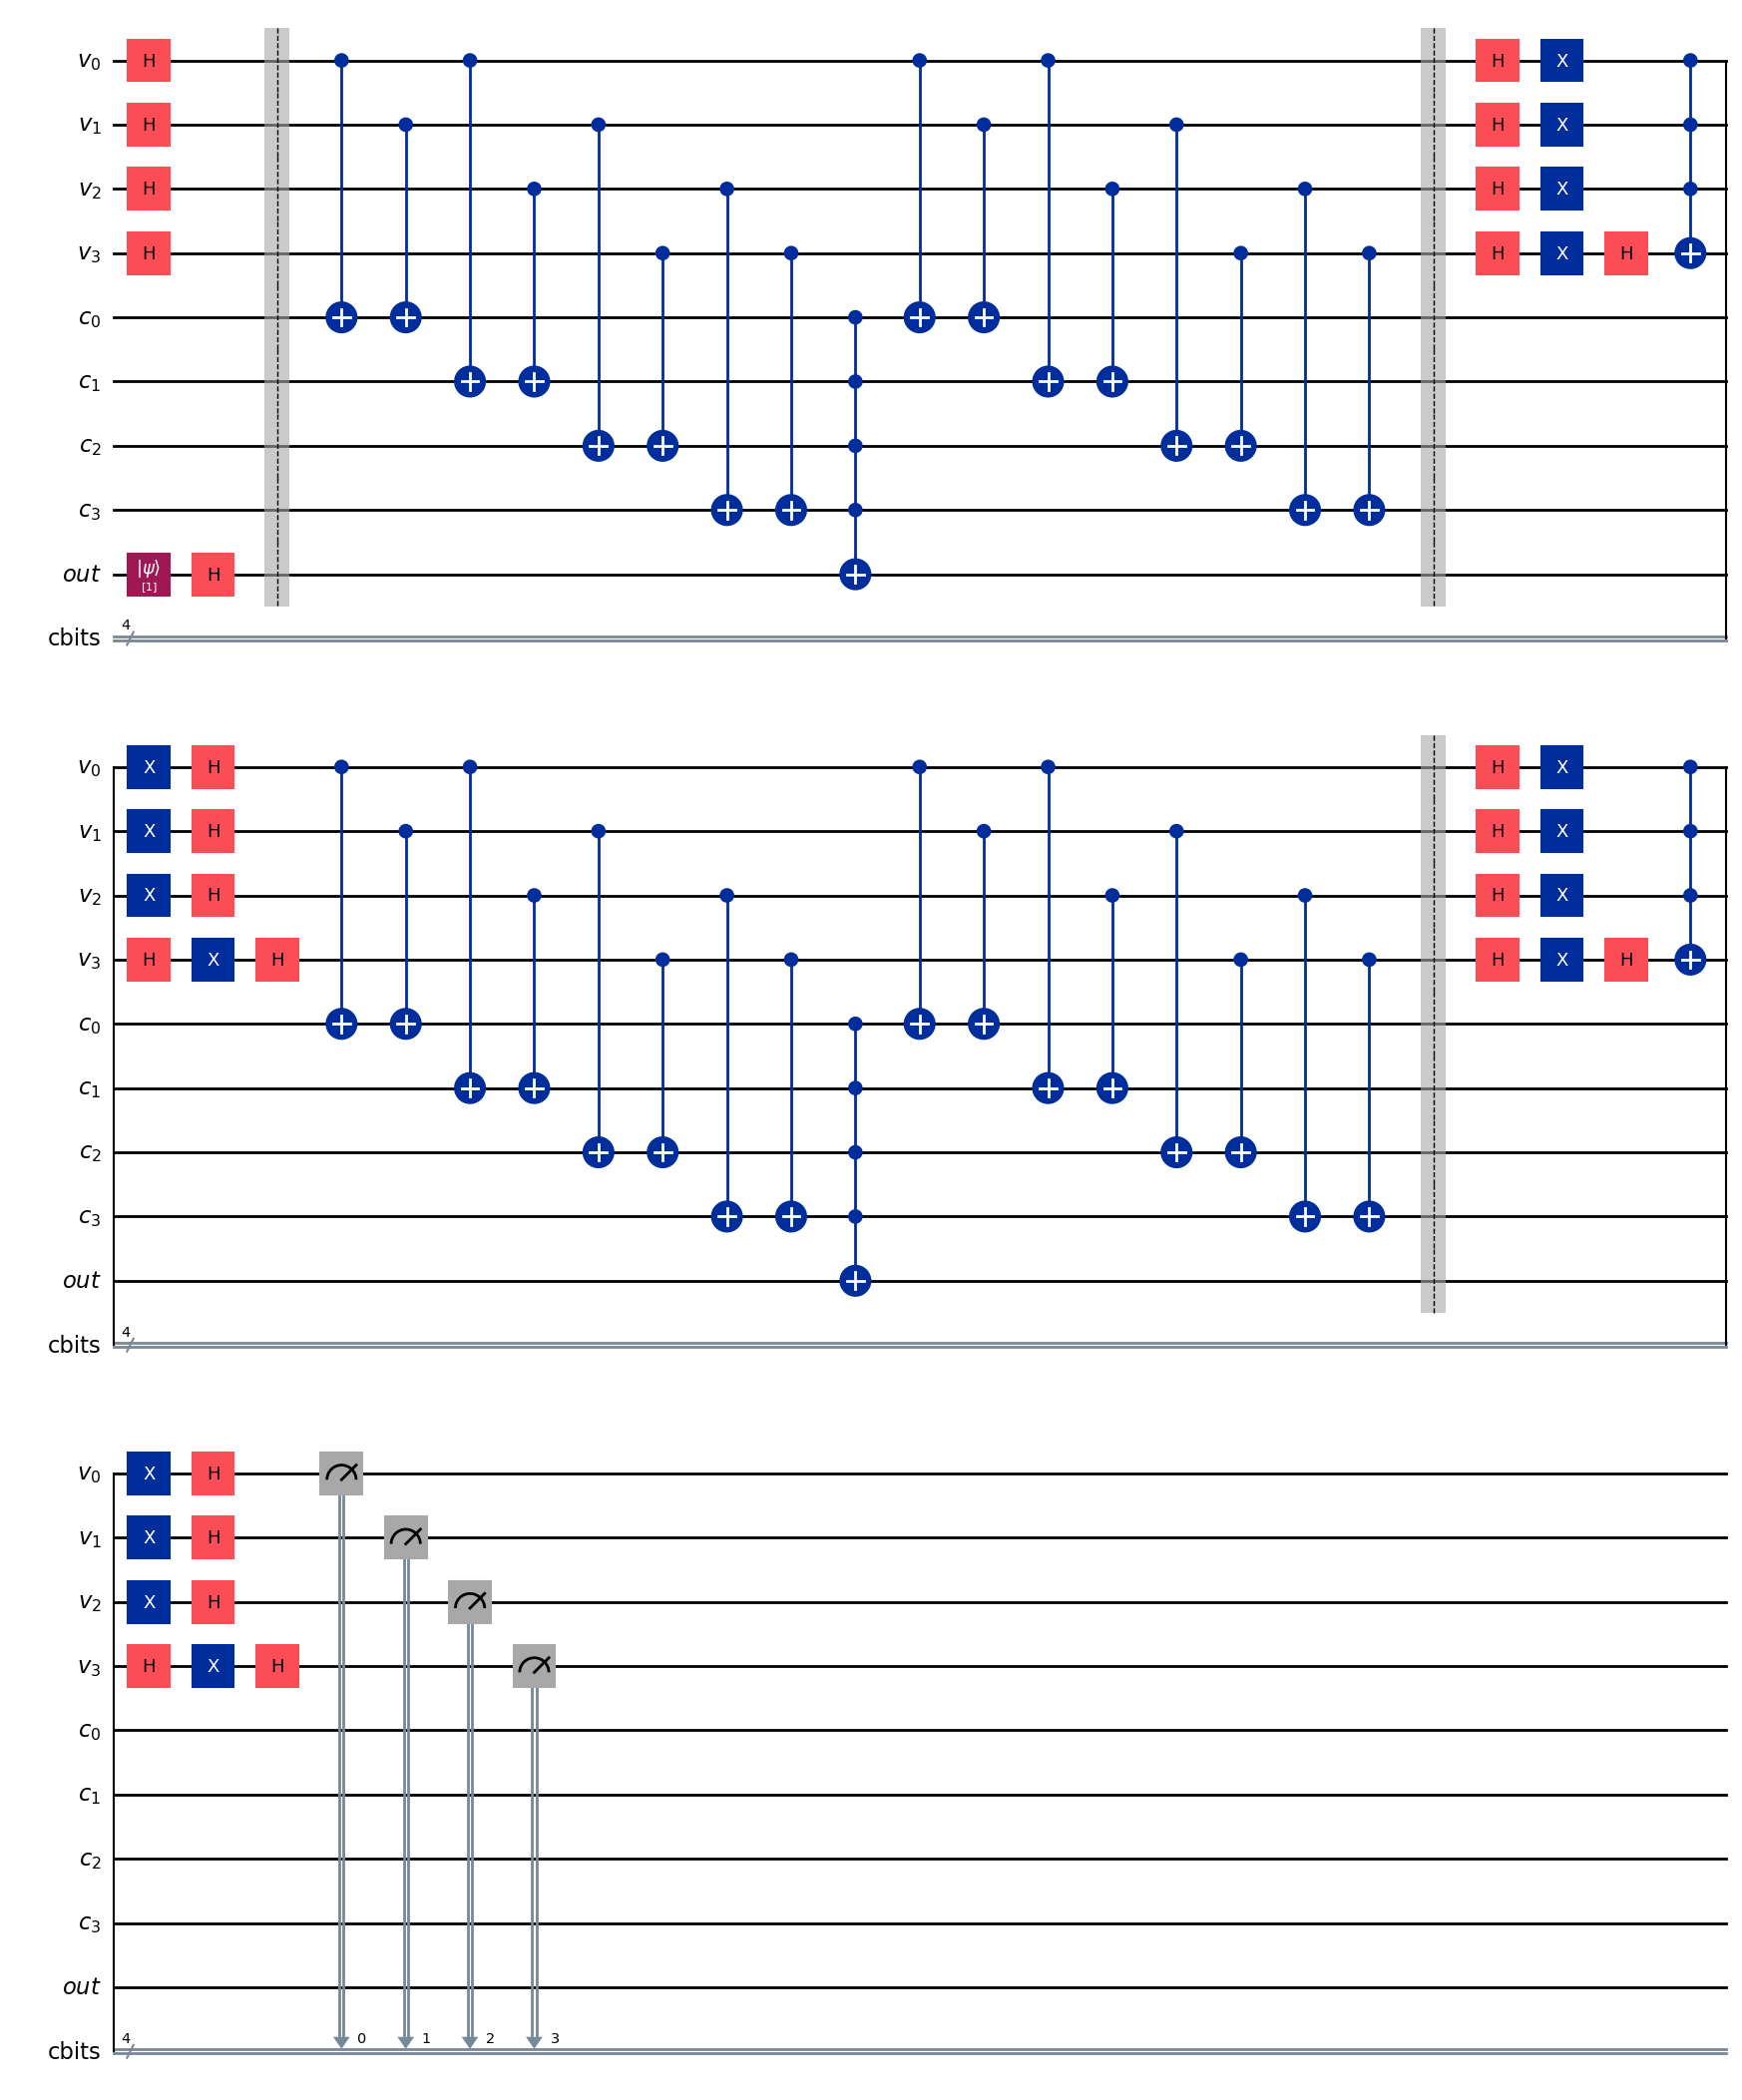

In [11]:
qc.initialize(1, output_qubit)

qc.h(var_qubits)
qc.h(output_qubit)
qc.barrier() # for visual separation

for i in range(iterations):
  # Apply oracle
  sudoku_oracle(qc, clause_list, clause_qubits)
  qc.barrier()  # for visual separation
  # Apply diffuser
  qc.h(var_qubits)
  qc.x(var_qubits)
  qc.h(var_qubits[3])
  qc.append(C3XGate(),[var_qubits[0], var_qubits[1], var_qubits[2], var_qubits[3]])
  qc.h(var_qubits[3])
  qc.x(var_qubits)
  qc.h(var_qubits)

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw('mpl')


In [12]:
qc.draw(fold=-1)

┌───┐            ░                                                                                       ░ ┌───┐┌───┐          ┌───┐┌───┐                                                                                           ░ ┌───┐┌───┐          ┌───┐┌───┐     ┌─┐         
    v_0: ──────┤ H ├────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────┤M├─────────
               ├───┤            ░   │         │                                  │         │                            ░ ├───┤├───┤       │  ├───┤├───┤       │         │                                  │         │                            ░ ├───┤├───┤       │  ├───┤├───┤     └╥┘┌─┐      
    v_1: ──────┤ H ├────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├──────
               ├───┤            ░   │    │    │         │                        │    │    │         │                  ░ ├───┤├───┤       │  ├───┤├───┤       │    │    │         │                        │    │    │         │                  ░ ├───┤├───┤       │  ├───┤├───┤      ║ └╥┘┌─┐   
    v_2: ──────┤ H ├────────────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫──╫─┤M├───
               ├───┤            ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  │    │    │    │    │         │              │    │    │    │    │         │        ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║  ║ └╥┘┌─┐
    v_3: ──────┤ H ├────────────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫──╫─┤M├
               └───┘            ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║  ║ └╥┘
    c_0: ───────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────────────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░─────────────────────────────────────╫──╫──╫──╫─
                                ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░                                    └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░                                     ║  ║  ║  ║ 
    c_1: ───────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░──────────────────────────────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░─────────────────────────────────────╫──╫──╫──╫─
                                ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                                              └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                                     ║  ║  ║  ║ 
    c_2: ───────────────────────░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░────────────────────────────────────────────────────────┤ X ├┤ X ├──┼────┼────■──────

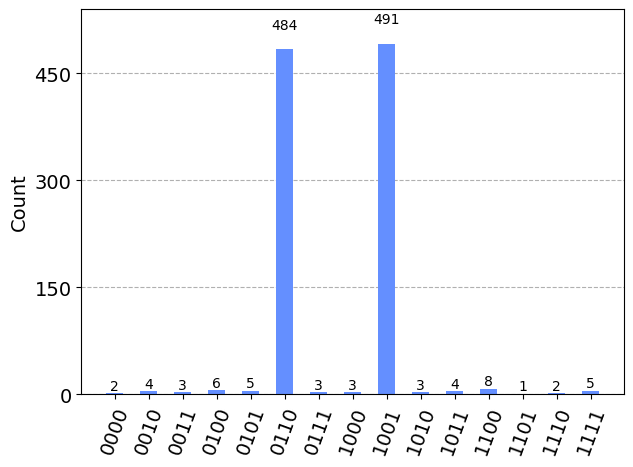

In [11]:
# Simulate and plot results
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)
result = simulator.run(transpiled_qc).result()
plot_histogram(result.get_counts(transpiled_qc))